In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import torch
import copy
# import torch_directml
# import lightning as L

In [2]:
torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [3]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [8]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([81, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 129, 55, 80],  
                              [111, 123, 76, 84],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,2))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(0),num_classes=2)
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(1),num_classes=2)
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete, axis=0)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


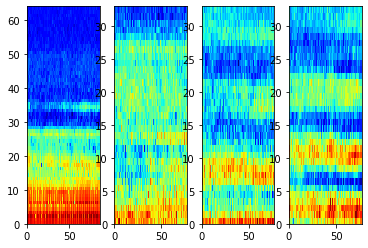

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### CNN1-model

In [75]:
class ALS_CNN1(nn.Module):
    def __init__(self):
        super(ALS_CNN1,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        input_chan = 2
        frames_in_segment = frames_in_segment - 1 # only for model with diff input
        self.layer1_filt = 4
        self.layer1_filt_hf = 1
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        # low/medium/high-frequency frequency span
        # low/medium/high-frequency time span
        lf1_height, lf1_width = 31,51 #29,43
        lf2_height, lf2_width = 19,31 #13,27
        lf3_height, lf3_width = 11,19 #5,11
        lf4_height, lf4_width = 9,11 #3,7
        lf5_height, lf5_width = 31,19

        mf1_height,mf1_width = 15,24 #15,31
        mf2_height,mf2_width =  9,15 #13,27
        mf3_height,mf3_width =  5,9
        mf4_height,mf4_width =  3,5
        mf5_height,mf5_width =  15,9

        hf1_height,hf1_width = 15,24    
        hf2_height,hf2_width =  9,15
        hf3_height,hf3_width =  5,9 #9,15
        hf4_height,hf4_width =  3,5 #3,3
        
        lf1_h_stride, lf1_w_stride = lf1_height//2, lf1_width//2
        lf2_h_stride, lf2_w_stride = lf2_height//2, lf2_width//2
        lf3_h_stride, lf3_w_stride = lf3_height//2, lf3_width//2
        lf4_h_stride, lf4_w_stride = lf4_height//2, lf4_width//2
        lf5_h_stride, lf5_w_stride = lf5_height//2, lf5_width//2

        mf1_h_stride, mf1_w_stride = mf1_height//2, mf1_width//2
        mf2_h_stride, mf2_w_stride = mf2_height//2, mf2_width//2
        mf3_h_stride, mf3_w_stride = mf3_height//2, mf3_width//2
        mf4_h_stride, mf4_w_stride = mf4_height//2, mf4_width//2
        mf5_h_stride, mf5_w_stride = mf5_height//2, mf5_width//2

        hf1_h_stride, hf1_w_stride = hf1_height//2, hf1_width//2
        hf2_h_stride, hf2_w_stride = hf2_height//2, hf2_width//2
        hf3_h_stride, hf3_w_stride = hf3_height//2, hf3_width//2
        hf4_h_stride, hf4_w_stride = hf4_height//2, hf4_width//2

        self.batch_norm1 = nn.BatchNorm2d(input_chan)    # device='cuda'
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf1_height, lf1_width),padding='valid',stride=(lf1_h_stride, lf1_w_stride))
        self.conv_lf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf2_height, lf2_width),padding='valid',stride=(lf2_h_stride, lf2_w_stride))
        self.conv_lf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf3_height, lf3_width),padding='valid',stride=(lf3_h_stride, lf3_w_stride))
        self.conv_lf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf4_height, lf4_width),padding='valid',stride=(lf4_h_stride, lf4_w_stride))
        self.conv_lf5 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf5_height, lf5_width),padding='valid',stride=(lf5_h_stride, lf5_w_stride))

        self.conv_mf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf1_height, mf1_width),padding='valid',stride=(mf1_h_stride, mf1_w_stride))
        self.conv_mf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf2_height, mf2_width),padding='valid',stride=(mf2_h_stride, mf2_w_stride))
        self.conv_mf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf3_height, mf3_width),padding='valid',stride=(mf3_h_stride, mf3_w_stride))
        self.conv_mf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf4_height, mf4_width),padding='valid',stride=(mf4_h_stride, mf4_w_stride))
        self.conv_mf5 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf5_height, mf5_width),padding='valid',stride=(mf5_h_stride, mf5_w_stride))

        self.conv_hf1 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf1_height, hf1_width),padding='valid',stride=(hf1_h_stride, hf1_w_stride))
        self.conv_hf2 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf2_height, hf2_width),padding='valid',stride=(hf2_h_stride, hf2_w_stride))
        self.conv_hf3 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf3_height, hf3_width),padding='valid',stride=(hf3_h_stride, hf3_w_stride))
        self.conv_hf4 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf4_height, hf4_width),padding='valid',stride=(hf4_h_stride, hf4_w_stride))

        max_pool_width = 1
        self.maxpool_lf1 = nn.MaxPool2d(((self.lf_num - lf1_height)//lf1_h_stride + 1,max_pool_width))        
        self.maxpool_lf2 = nn.MaxPool2d(((self.lf_num - lf2_height)//lf2_h_stride + 1,max_pool_width))
        self.maxpool_lf3 = nn.MaxPool2d(((self.lf_num - lf3_height)//lf3_h_stride + 1,max_pool_width))
        self.maxpool_lf4 = nn.MaxPool2d(((self.lf_num - lf4_height)//lf4_h_stride + 1,max_pool_width))
        self.maxpool_lf5 = nn.MaxPool2d(((self.lf_num - lf5_height)//lf5_h_stride + 1,max_pool_width))

        self.maxpool_mf1 = nn.MaxPool2d(((self.mf_num - mf1_height)//mf1_h_stride + 1,max_pool_width))
        self.maxpool_mf2 = nn.MaxPool2d(((self.mf_num - mf2_height)//mf2_h_stride + 1,max_pool_width))
        self.maxpool_mf3 = nn.MaxPool2d(((self.mf_num - mf3_height)//mf3_h_stride + 1,max_pool_width))
        self.maxpool_mf4 = nn.MaxPool2d(((self.mf_num - mf4_height)//mf4_h_stride + 1,max_pool_width))
        self.maxpool_mf5 = nn.MaxPool2d(((self.mf_num - mf5_height)//mf5_h_stride + 1,max_pool_width))

        self.maxpool_hf1 = nn.MaxPool2d(((self.hf_num - hf1_height)//hf1_h_stride + 1,max_pool_width))
        self.maxpool_hf2 = nn.MaxPool2d(((self.hf_num - hf2_height)//hf2_h_stride + 1,max_pool_width))
        self.maxpool_hf3 = nn.MaxPool2d(((self.hf_num - hf3_height)//hf3_h_stride + 1,max_pool_width))
        self.maxpool_hf4 = nn.MaxPool2d(((self.hf_num - hf4_height)//hf4_h_stride + 1,max_pool_width))

        self.drop1 = nn.Dropout(p=0.1)                        

        self.fc = nn.Linear(
                            self.layer1_filt*((1+(frames_in_segment-lf1_width)//lf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf2_width)//lf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf3_width)//lf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf4_width)//lf4_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf5_width)//lf5_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf1_width)//mf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf2_width)//mf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf3_width)//mf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf4_width)//mf4_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf5_width)//mf5_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf1_width)//hf1_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf2_width)//hf2_w_stride)//max_pool_width) + 
                            self.layer1_filt_hf*((1+(frames_in_segment-hf3_width)//hf3_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf4_width)//hf4_w_stride)//max_pool_width)
                            ,2)                               

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf1.weight)
        torch.manual_seed(511)
        nn.init.xavier_uniform_(self.conv_lf2.weight)
        torch.manual_seed(1511)
        nn.init.xavier_uniform_(self.conv_lf3.weight)
        torch.manual_seed(2511)
        nn.init.xavier_uniform_(self.conv_lf4.weight)
        torch.manual_seed(1111)
        nn.init.xavier_uniform_(self.conv_lf5.weight)
        torch.manual_seed(111)
        nn.init.xavier_uniform_(self.conv_mf1.weight)
        torch.manual_seed(11)
        nn.init.xavier_uniform_(self.conv_mf2.weight)
        torch.manual_seed(15)
        nn.init.xavier_uniform_(self.conv_mf3.weight)
        torch.manual_seed(115)
        nn.init.xavier_uniform_(self.conv_mf4.weight)
        torch.manual_seed(59)
        nn.init.xavier_uniform_(self.conv_mf5.weight)
        torch.manual_seed(1115)
        nn.init.xavier_uniform_(self.conv_hf1.weight)
        torch.manual_seed(1615)
        nn.init.xavier_uniform_(self.conv_hf2.weight)
        torch.manual_seed(615)
        nn.init.xavier_uniform_(self.conv_hf3.weight)
        torch.manual_seed(815)
        nn.init.xavier_uniform_(self.conv_hf4.weight)
        torch.manual_seed(855)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x): 
        
        # print('x size', x.shape)
        x_diff = x[:,:,:,1:] - x[:,:,:,0:-1]
        # print('x_diff', x_diff.shape)
        # print('x', x[:,:,:,1:].shape)
        out = torch.cat((x[:,:,:,1:],x_diff), dim=1)
        # print('x merge', out.shape)

        out = self.batch_norm1(out)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        out_lf2 = out1.detach()
        out_lf3 = out1.detach()
        out_lf4 = out1.detach()
        out_lf5 = out1.detach()

        out_mf2,out_mf3,out_mf4,out_mf5 = out2.detach(),out2.detach(),out2.detach(),out2.detach()         
        
        out_hf2 = out3.detach()
        out_hf3 = out3.detach()
        out_hf4 = out3.detach()

        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())        
        
        
        out1 = torch.nn.functional.elu(self.conv_lf1(out1))
        out_lf2 = torch.nn.functional.elu(self.conv_lf2(out_lf2))
        out_lf3 = torch.nn.functional.elu(self.conv_lf3(out_lf3))
        out_lf4 = torch.nn.functional.elu(self.conv_lf4(out_lf4))
        out_lf5 = torch.nn.functional.elu(self.conv_lf5(out_lf5))

        out2 = torch.nn.functional.elu(self.conv_mf1(out2))
        out_mf2 = torch.nn.functional.elu(self.conv_mf2(out_mf2))
        out_mf3 = torch.nn.functional.elu(self.conv_mf3(out_mf3))
        out_mf4 = torch.nn.functional.elu(self.conv_mf4(out_mf4))
        out_mf5 = torch.nn.functional.elu(self.conv_mf5(out_mf5))

        out3 = torch.nn.functional.elu(self.conv_hf1(out3))
        out_hf2 = torch.nn.functional.elu(self.conv_hf2(out_hf2))
        out_hf3 = torch.nn.functional.elu(self.conv_hf3(out_hf3))
        out_hf4 = torch.nn.functional.elu(self.conv_hf4(out_hf4))

        out1 = self.maxpool_lf1(out1)        
        out_lf2 = self.maxpool_lf2(out_lf2)
        out_lf3 = self.maxpool_lf3(out_lf3)
        out_lf4 = self.maxpool_lf4(out_lf4)
        out_lf5 = self.maxpool_lf5(out_lf5)

        out2 = self.maxpool_mf1(out2)
        out_mf2 = self.maxpool_mf2(out_mf2)
        out_mf3 = self.maxpool_mf3(out_mf3)
        out_mf4 = self.maxpool_mf4(out_mf4)
        out_mf5 = self.maxpool_mf5(out_mf5)

        out3 = self.maxpool_hf1(out3)
        out_hf2 = self.maxpool_hf2(out_hf2)
        out_hf3 = self.maxpool_hf3(out_hf3)
        out_hf4 = self.maxpool_hf4(out_hf4)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out_lf2 = out_lf2.view(-1, out_lf2.shape[1]*out_lf2.shape[2]*out_lf2.shape[3])
        out_lf3 = out_lf3.view(-1, out_lf3.shape[1]*out_lf3.shape[2]*out_lf3.shape[3])
        out_lf4 = out_lf4.view(-1, out_lf4.shape[1]*out_lf4.shape[2]*out_lf4.shape[3])
        out_lf5 = out_lf5.view(-1, out_lf5.shape[1]*out_lf5.shape[2]*out_lf5.shape[3])

        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out_mf2 = out_mf2.view(-1, out_mf2.shape[1]*out_mf2.shape[2]*out_mf2.shape[3])
        out_mf3 = out_mf3.view(-1, out_mf3.shape[1]*out_mf3.shape[2]*out_mf3.shape[3])
        out_mf4 = out_mf4.view(-1, out_mf4.shape[1]*out_mf4.shape[2]*out_mf4.shape[3])
        out_mf5 = out_mf5.view(-1, out_mf5.shape[1]*out_mf5.shape[2]*out_mf5.shape[3])

        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])
        out_hf2 = out_hf2.view(-1, out_hf2.shape[1]*out_hf2.shape[2]*out_hf2.shape[3])
        out_hf3 = out_hf3.view(-1, out_hf3.shape[1]*out_hf3.shape[2]*out_hf3.shape[3])
        out_hf4 = out_hf4.view(-1, out_hf4.shape[1]*out_hf4.shape[2]*out_hf4.shape[3])

        out = torch.cat((out1, out_lf2, out_lf3, out_lf4, out_lf5,
                         out2, out_mf2, out_mf3, out_mf4, out_mf5,
                         out3, out_hf2, out_hf3, out_hf4
                         ), 1)  
        
        # print('fc.weight: ', self.fc.weight.shape)
        # print('out: ', out.shape)

        out = self.drop1(out)        

        out = self.fc(out)
        return out  

#### CNN2-model

In [70]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 1#18
        layer2_filt = 1#8
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,15,15      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 15,5,5        # low/medium/high-frequency frequency span

        l2_kernel_size = 2

        lf_h_stride, mf_h_stride, hf_h_stride = lf_height//2, mf_height//2, hf_height//2
        lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2,  hf_width//2,  hf_height//2

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.batch_norm_lf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_mf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_hf = nn.BatchNorm2d(layer1_filt)

        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,2)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)

        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = self.batch_norm_lf(out1)
        out2 = self.batch_norm_mf(out2)
        out3 = self.batch_norm_hf(out3)

        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out

#### training_loop

In [73]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    best_epoch = -1
    loss_val_min = 100
    for epoch in range(1,n_epochs+1):        
        model.train()        
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        loss_train = loss_train / len(train_loader)

        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        total = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()

                _,pred = torch.max(pred, dim=1)
                _,label = torch.max(label, dim=1)
                        
                total += len(label)

                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/total
        loss_val = loss_val / len(val_loader)
        
        loss_train_history[epoch-1] = loss_train
        loss_val_history[epoch-1] = loss_val

        if loss_val < loss_val_min:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_min = loss_val
            best_epoch = epoch-1

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train:.3f}, Val loss {loss_val:.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.plot(best_epoch,loss_val_min,color='red', marker='o', linewidth=1, markersize=5)
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history,loss_val_min,best_epoch)

### Single NN training & evaluation

In [27]:
# Test inference
model = ALS_CNN1()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)
print(y_out.shape)

torch.Size([1, 1, 64, 86])
torch.Size([1, 2])


C:\Users\Admin\AppData\Local\Temp\ipykernel_12380\767754608.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X, dtype=torch.float)


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [51]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    loss_val_best_hist = list()
    best_epoch_hist = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history,loss_val_best,best_epoch = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)
        loss_val_best_hist.append(loss_val_best)
        best_epoch_hist.append(best_epoch)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                pred = model(spec)
                # pred = torch.squeeze(pred,1)
                pred = torch.squeeze(pred)
                pred = torch.squeeze(pred)  
                label = torch.squeeze(label,0)
                
                # print('pred.shape', pred.shape)
                # print('pred', pred)
                # print('label.shape', label.shape)
                # print('label', label)

                # test_score.append(pred.numpy())
                test_score.append(pred[1].numpy())
                if pred[1]>pred[0]: #pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                    if label[1]>label[0]:
                        TP_TN_sum +=1    # TP
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0 
                    if label[0]>label[1]:
                        TP_TN_sum +=1    # TN                   
                y_true[inds_test[i]] = 1*(label[1]>label[0]) #label

                # if pred==label:
                #     TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.plot(best_epoch_hist[i],loss_val_best_hist[i],color='red', marker='o', linewidth=1, markersize=5)
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epochs. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')
    # print(f'Prec = {prec:.2f}')
    # print(f'Recall = {recall:.2f}')
    # print(f'')    
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

In [ ]:
# dir_HC = '../wav'+ os.sep + 'HC' + os.sep
# dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# Start parameters
# layer1_filt = 64
# lf_num, mf_num, hf_num = 32,16,16    # low-frequency / medium-frequency / high-frequency       
# lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
# lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span
# lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
# lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.56 (Sens = 0.47 / Spec = 0.65) 0.66 / 0.37 / 0.64 / 0.62 / 0.55
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.66) 0.65 / 0.82 / 0.72 / 0.78 / 0.61
# lf_height = 24
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.63 (Sens = 0.75 / Spec = 0.51) 0.72 / 0.71 / 0.59 / 0.63 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.61 (Sens = 0.73 / Spec = 0.49) 0.62 / 0.68 / 0.57 / 0.64 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.75 (Sens = 0.78 / Spec = 0.71) 0.68 / 0.85 / 0.66 / 0.68 / 0.87 (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 30 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.71 / 0.82 / 0.73 / 0.67 / 0.86
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.73 / 0.88 / 0.67 / 0.65 / 0.87
# mf_height = 12 (old val 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.73) 0.80 / 0.88 / 0.70 / 0.65 / 0.84
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.77 / 0.86 / 0.71 / 0.64 / 0.73
# hf_height = 12 (old val 8) 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.70) 0.67 / 0.89 / 0.65 / 0.66 / 0.810
# hf_height = 8 (return), mf_height = 16 (old val 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.71) 0.83 / 0.92 / 0.58 / 0.65 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 100 epochs. Acc_sk = 0.65 (Sens = 0.64 / Spec = 0.66) 0.62 / 0.73 / 0.58 / 0.72 / 0.66
# lf_width = 24 (old value 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.84 / 0.93 / 0.60 / 0.64 / 0.85
# mf_width = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.77 / 0.89 / 0.59 / 0.67 / 0.91
# hf_height = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.68 / 0.89 / 0.58 / 0.75 / 0.94
# mf_height = 15 (old value 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.70 / 0.86 / 0.57 / 0.75 / 0.94
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.64 / 0.84 / 0.55 / 0.75 / 0.85
# lf_width = 48 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.68 / 0.84 / 0.55 / 0.74 / 0.89
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 24 (return) + hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.76 / 0.87 / 0.54 / 0.69 / 0.87
# mf_height = 12 (before 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.82 / Spec = 0.74) 0.80 / 0.85 / 0.68 / 0.65 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.79 / 0.86 / 0.64 / 0.65 / 0.76
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.68) 0.69 / 0.67 / 0.64 / 0.67 / 0.85
# hf_height = 12 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.65 / 0.86 / 0.65 / 0.68 / 0.88
# hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.72) 0.76 / 0.86 / 0.68 / 0.65 / 0.88
# hf_height = 10 (8 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.75 / 0.85 / 0.64 / 0.66 / 0.87
# hf_height = 8 (return) + hf_width = 8 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.79 / 0.86 / 0.64 / 0.63 / 0.76
# return to model with 78% Acc
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.75 / 0.83 / 0.66 / 0.65 / 0.83
# xavier_uniform changed to kaiming_normal_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.63 / 0.88 / 0.53 / 0.75 / 0.94 (good behaviour)
# kaiming_normal_ changed to kaiming_uniform_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.75 / Spec = 0.65) 0.62 / 0.87 / 0.53 / 0.77 / 0.79
# kaiming_uniform_ 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.69) 0.65 / 0.88 / 0.53 / 0.75 / 0.95
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.69 / 0.80 / 0.54 / 0.75 / 0.93
# hf_width = 5 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.65 / 0.84 / 0.58 / 0.74 / 0.90
# xavier_uniform (return) + nn.init.xavier_uniform_(self.fc)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.66) 0.60 / 0.65 / 0.62 / 0.64 / 0.82 (slow curves)
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.69) 0.75 / 0.83 / 0.58 / 0.66 / 0.79 
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.72 / Spec = 0.67) 0.74 / 0.79 / 0.60 / 0.66 / 0.73
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.71) 0.72 / 0.88 / 0.60 / 0.66 / 0.84
# lf_width = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.77 / 0.86 / 0.67 / 0.65 / 0.83
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.73 / 0.65 / 0.74
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.79 / Spec = 0.70) 0.78 / 0.90 / 0.73 / 0.65 / 0.74
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# mf_height = 15 (before 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.71 / 0.65 / 0.75
# mf_width, mf_height = 13,13
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.81 / 0.94 / 0.65 / 0.65 / 0.74
# mf_width, mf_height = 15,15 (return)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.62 (Sens = 0.60 / Spec = 0.65) 0.50 / 0.74 / 0.59 / 0.72 / 0.63
# hf_width,hf_height = 5,5
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75
# mf_height,mf_width = 15,17 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.76 / Spec = 0.66) 0.68 / 0.74 / 0.56 / 0.67 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.73 (Sens = 0.80 / Spec = 0.65) 0.70 / 0.77 / 0.59 / 0.67 / 0.87
# self.layer1_filt = 3 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.82 / Spec = 0.65) 0.72 / 0.82 / 0.57 / 0.74 / 0.84
# self.layer1_filt = 2 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.70) 0.70 / 0.71 / 0.60 / 0.64 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.75 / 0.79 / 0.60 / 0.65 / 0.84
# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.65 (Sens = 0.69 / Spec = 0.61) 0.62 / 0.81 / 0.57 / 0.71 / 0.62
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.8) # 15 epochs. Acc_sk = 0.72 (Sens = 0.74 / Spec = 0.70) 0.73 / 0.80 / 0.58 / 0.65 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.69 / Spec = 0.69) 0.68 / 0.62 / 0.63 / 0.66 / 0.83
# add second convolution with middle freq mf_height,mf_width = 7,7
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.68 / 0.85 / 0.59 / 0.64 / 0.84
# dropout = 0.1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.68) 0.69 / 0.87 / 0.58 / 0.67 / 0.84
# mf_height,mf_width = 7,33
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.70 (Sens = 0.78 / Spec = 0.62) 0.75 / 0.69 / 0.56 / 0.73 / 0.76 (good curves. need more iterations)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)


#### Test CNN1 (5-fold CV)

Epoch 1: 100%|██████████| 125/125 [00:11<00:00, 10.81it/s]


2023-06-06 19:06:05.542510 Epoch 1, Train loss 0.768, Val loss 0.709, Acc_val = 0.52


Epoch 2: 100%|██████████| 125/125 [00:10<00:00, 12.44it/s]


2023-06-06 19:06:16.079916 Epoch 2, Train loss 0.727, Val loss 0.711, Acc_val = 0.51


Epoch 3: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]


2023-06-06 19:06:27.035506 Epoch 3, Train loss 0.708, Val loss 0.715, Acc_val = 0.50


Epoch 4: 100%|██████████| 125/125 [00:09<00:00, 12.62it/s]


2023-06-06 19:06:37.412373 Epoch 4, Train loss 0.693, Val loss 0.705, Acc_val = 0.52


Epoch 5: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s]


2023-06-06 19:06:48.282114 Epoch 5, Train loss 0.677, Val loss 0.708, Acc_val = 0.52


Epoch 6: 100%|██████████| 125/125 [00:09<00:00, 12.52it/s]


2023-06-06 19:06:58.736649 Epoch 6, Train loss 0.665, Val loss 0.706, Acc_val = 0.53


Epoch 7: 100%|██████████| 125/125 [00:10<00:00, 12.18it/s]


2023-06-06 19:07:09.461286 Epoch 7, Train loss 0.650, Val loss 0.694, Acc_val = 0.56


Epoch 8: 100%|██████████| 125/125 [00:10<00:00, 12.15it/s]


2023-06-06 19:07:20.245366 Epoch 8, Train loss 0.639, Val loss 0.691, Acc_val = 0.58


Epoch 9: 100%|██████████| 125/125 [00:10<00:00, 12.21it/s]


2023-06-06 19:07:30.985637 Epoch 9, Train loss 0.622, Val loss 0.689, Acc_val = 0.59


Epoch 10: 100%|██████████| 125/125 [00:10<00:00, 12.38it/s]


2023-06-06 19:07:41.555056 Epoch 10, Train loss 0.610, Val loss 0.684, Acc_val = 0.61


Epoch 11: 100%|██████████| 125/125 [00:10<00:00, 12.28it/s]


2023-06-06 19:07:52.201018 Epoch 11, Train loss 0.596, Val loss 0.676, Acc_val = 0.63


Epoch 12: 100%|██████████| 125/125 [00:10<00:00, 12.26it/s]


2023-06-06 19:08:02.877381 Epoch 12, Train loss 0.581, Val loss 0.662, Acc_val = 0.63


Epoch 13: 100%|██████████| 125/125 [00:10<00:00, 12.34it/s]


2023-06-06 19:08:13.463772 Epoch 13, Train loss 0.569, Val loss 0.649, Acc_val = 0.64


Epoch 14: 100%|██████████| 125/125 [00:10<00:00, 11.87it/s]


2023-06-06 19:08:24.459869 Epoch 14, Train loss 0.554, Val loss 0.645, Acc_val = 0.65


Epoch 15: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s]


2023-06-06 19:08:35.295327 Epoch 15, Train loss 0.539, Val loss 0.626, Acc_val = 0.65


Epoch 16: 100%|██████████| 125/125 [00:10<00:00, 12.13it/s]


2023-06-06 19:08:46.095588 Epoch 16, Train loss 0.527, Val loss 0.613, Acc_val = 0.66


Epoch 17: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s]


2023-06-06 19:08:56.872002 Epoch 17, Train loss 0.515, Val loss 0.603, Acc_val = 0.66


Epoch 18: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s]


2023-06-06 19:09:07.797251 Epoch 18, Train loss 0.502, Val loss 0.596, Acc_val = 0.67


Epoch 19: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s]


2023-06-06 19:09:18.581177 Epoch 19, Train loss 0.492, Val loss 0.590, Acc_val = 0.67


Epoch 20: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s]


2023-06-06 19:09:29.430800 Epoch 20, Train loss 0.482, Val loss 0.577, Acc_val = 0.67


Epoch 21: 100%|██████████| 125/125 [00:10<00:00, 12.17it/s]


2023-06-06 19:09:40.184721 Epoch 21, Train loss 0.470, Val loss 0.567, Acc_val = 0.67


Epoch 22: 100%|██████████| 125/125 [00:10<00:00, 12.15it/s]


2023-06-06 19:09:50.941780 Epoch 22, Train loss 0.463, Val loss 0.564, Acc_val = 0.66


Epoch 23: 100%|██████████| 125/125 [00:10<00:00, 12.16it/s]


2023-06-06 19:10:01.714877 Epoch 23, Train loss 0.454, Val loss 0.568, Acc_val = 0.65


Epoch 24: 100%|██████████| 125/125 [00:10<00:00, 12.29it/s]


2023-06-06 19:10:12.340567 Epoch 24, Train loss 0.448, Val loss 0.554, Acc_val = 0.66


Epoch 25: 100%|██████████| 125/125 [00:10<00:00, 12.34it/s]


2023-06-06 19:10:22.953790 Epoch 25, Train loss 0.441, Val loss 0.553, Acc_val = 0.66


Epoch 26: 100%|██████████| 125/125 [00:10<00:00, 11.76it/s]


2023-06-06 19:10:34.084083 Epoch 26, Train loss 0.435, Val loss 0.544, Acc_val = 0.65


Epoch 27: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]


2023-06-06 19:10:44.990453 Epoch 27, Train loss 0.428, Val loss 0.549, Acc_val = 0.64


Epoch 28: 100%|██████████| 125/125 [00:10<00:00, 12.25it/s]


2023-06-06 19:10:55.670141 Epoch 28, Train loss 0.425, Val loss 0.547, Acc_val = 0.64


Epoch 29: 100%|██████████| 125/125 [00:10<00:00, 11.94it/s]


2023-06-06 19:11:06.603523 Epoch 29, Train loss 0.419, Val loss 0.542, Acc_val = 0.64


Epoch 30: 100%|██████████| 125/125 [00:10<00:00, 11.70it/s]


2023-06-06 19:11:17.760862 Epoch 30, Train loss 0.415, Val loss 0.534, Acc_val = 0.65


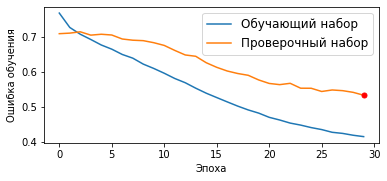

Acc =  0.7476822851415685


Epoch 1: 100%|██████████| 134/134 [00:11<00:00, 11.73it/s]


2023-06-06 19:11:40.696299 Epoch 1, Train loss 0.766, Val loss 0.692, Acc_val = 0.60


Epoch 2: 100%|██████████| 134/134 [00:10<00:00, 12.29it/s]


2023-06-06 19:11:51.794135 Epoch 2, Train loss 0.725, Val loss 0.711, Acc_val = 0.55


Epoch 3: 100%|██████████| 134/134 [00:11<00:00, 12.12it/s]


2023-06-06 19:12:03.050785 Epoch 3, Train loss 0.696, Val loss 0.725, Acc_val = 0.54


Epoch 4: 100%|██████████| 134/134 [00:10<00:00, 12.23it/s]


2023-06-06 19:12:14.200700 Epoch 4, Train loss 0.680, Val loss 0.733, Acc_val = 0.52


Epoch 5: 100%|██████████| 134/134 [00:10<00:00, 12.28it/s]


2023-06-06 19:12:25.311217 Epoch 5, Train loss 0.664, Val loss 0.733, Acc_val = 0.51


Epoch 6: 100%|██████████| 134/134 [00:10<00:00, 12.20it/s]


2023-06-06 19:12:36.490429 Epoch 6, Train loss 0.646, Val loss 0.729, Acc_val = 0.51


Epoch 7: 100%|██████████| 134/134 [00:10<00:00, 12.24it/s]


2023-06-06 19:12:47.632707 Epoch 7, Train loss 0.630, Val loss 0.721, Acc_val = 0.51


Epoch 8: 100%|██████████| 134/134 [00:10<00:00, 12.27it/s]


2023-06-06 19:12:58.747406 Epoch 8, Train loss 0.613, Val loss 0.708, Acc_val = 0.54


Epoch 9: 100%|██████████| 134/134 [00:11<00:00, 12.14it/s]


2023-06-06 19:13:09.980744 Epoch 9, Train loss 0.597, Val loss 0.697, Acc_val = 0.58


Epoch 10: 100%|██████████| 134/134 [00:11<00:00, 12.08it/s]


2023-06-06 19:13:21.287394 Epoch 10, Train loss 0.581, Val loss 0.683, Acc_val = 0.61


Epoch 11: 100%|██████████| 134/134 [00:11<00:00, 12.12it/s]


2023-06-06 19:13:32.557742 Epoch 11, Train loss 0.569, Val loss 0.676, Acc_val = 0.62


Epoch 12: 100%|██████████| 134/134 [00:11<00:00, 12.17it/s]


2023-06-06 19:13:43.792158 Epoch 12, Train loss 0.555, Val loss 0.664, Acc_val = 0.67


Epoch 13: 100%|██████████| 134/134 [00:10<00:00, 12.32it/s]


2023-06-06 19:13:54.885102 Epoch 13, Train loss 0.543, Val loss 0.659, Acc_val = 0.67


Epoch 14: 100%|██████████| 134/134 [00:11<00:00, 12.09it/s]


2023-06-06 19:14:06.181014 Epoch 14, Train loss 0.533, Val loss 0.647, Acc_val = 0.70


Epoch 15: 100%|██████████| 134/134 [00:11<00:00, 12.14it/s]


2023-06-06 19:14:17.422052 Epoch 15, Train loss 0.522, Val loss 0.646, Acc_val = 0.70


Epoch 16: 100%|██████████| 134/134 [00:11<00:00, 11.76it/s]


2023-06-06 19:14:29.009192 Epoch 16, Train loss 0.514, Val loss 0.637, Acc_val = 0.74


Epoch 17: 100%|██████████| 134/134 [00:11<00:00, 11.27it/s]


2023-06-06 19:14:41.170189 Epoch 17, Train loss 0.506, Val loss 0.636, Acc_val = 0.74


Epoch 18: 100%|██████████| 134/134 [00:11<00:00, 11.93it/s]


2023-06-06 19:14:52.601338 Epoch 18, Train loss 0.496, Val loss 0.642, Acc_val = 0.71


Epoch 19: 100%|██████████| 134/134 [00:10<00:00, 12.27it/s]


2023-06-06 19:15:03.771556 Epoch 19, Train loss 0.492, Val loss 0.641, Acc_val = 0.68


Epoch 20: 100%|██████████| 134/134 [00:11<00:00, 11.80it/s]


2023-06-06 19:15:15.364084 Epoch 20, Train loss 0.483, Val loss 0.629, Acc_val = 0.75


Epoch 21: 100%|██████████| 134/134 [00:11<00:00, 11.90it/s]


2023-06-06 19:15:26.823488 Epoch 21, Train loss 0.476, Val loss 0.637, Acc_val = 0.72


Epoch 22: 100%|██████████| 134/134 [00:11<00:00, 11.96it/s]


2023-06-06 19:15:38.317343 Epoch 22, Train loss 0.468, Val loss 0.645, Acc_val = 0.65


Epoch 23: 100%|██████████| 134/134 [00:12<00:00, 11.00it/s]


2023-06-06 19:15:50.715764 Epoch 23, Train loss 0.464, Val loss 0.643, Acc_val = 0.69


Epoch 24: 100%|██████████| 134/134 [00:12<00:00, 11.01it/s]


2023-06-06 19:16:03.109362 Epoch 24, Train loss 0.458, Val loss 0.646, Acc_val = 0.65


Epoch 25: 100%|██████████| 134/134 [00:12<00:00, 11.10it/s]


2023-06-06 19:16:15.396676 Epoch 25, Train loss 0.450, Val loss 0.651, Acc_val = 0.59


Epoch 26: 100%|██████████| 134/134 [00:12<00:00, 10.98it/s]


2023-06-06 19:16:27.839627 Epoch 26, Train loss 0.445, Val loss 0.653, Acc_val = 0.56


Epoch 27: 100%|██████████| 134/134 [00:11<00:00, 11.35it/s]


2023-06-06 19:16:39.862487 Epoch 27, Train loss 0.440, Val loss 0.657, Acc_val = 0.56


Epoch 28: 100%|██████████| 134/134 [00:12<00:00, 10.56it/s]


2023-06-06 19:16:52.796538 Epoch 28, Train loss 0.435, Val loss 0.669, Acc_val = 0.50


Epoch 29: 100%|██████████| 134/134 [00:12<00:00, 10.40it/s]


2023-06-06 19:17:05.898359 Epoch 29, Train loss 0.428, Val loss 0.667, Acc_val = 0.50


Epoch 30: 100%|██████████| 134/134 [00:12<00:00, 10.79it/s]


2023-06-06 19:17:18.560330 Epoch 30, Train loss 0.423, Val loss 0.671, Acc_val = 0.50


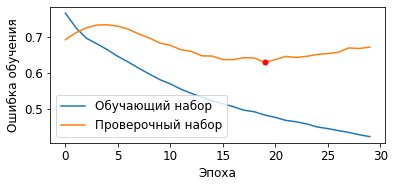

Acc =  0.7655400614511936


Epoch 1: 100%|██████████| 127/127 [00:11<00:00, 10.89it/s]


2023-06-06 19:17:44.662744 Epoch 1, Train loss 0.723, Val loss 0.768, Acc_val = 0.53


Epoch 2: 100%|██████████| 127/127 [00:11<00:00, 10.61it/s]


2023-06-06 19:17:57.025501 Epoch 2, Train loss 0.681, Val loss 0.759, Acc_val = 0.53


Epoch 3: 100%|██████████| 127/127 [00:11<00:00, 11.42it/s]


2023-06-06 19:18:08.500048 Epoch 3, Train loss 0.647, Val loss 0.758, Acc_val = 0.52


Epoch 4: 100%|██████████| 127/127 [00:10<00:00, 12.23it/s]


2023-06-06 19:18:19.220994 Epoch 4, Train loss 0.616, Val loss 0.756, Acc_val = 0.54


Epoch 5: 100%|██████████| 127/127 [00:10<00:00, 12.39it/s]


2023-06-06 19:18:29.807631 Epoch 5, Train loss 0.587, Val loss 0.756, Acc_val = 0.52


Epoch 6: 100%|██████████| 127/127 [00:10<00:00, 12.19it/s]


2023-06-06 19:18:40.560648 Epoch 6, Train loss 0.559, Val loss 0.756, Acc_val = 0.54


Epoch 7: 100%|██████████| 127/127 [00:10<00:00, 12.09it/s]


2023-06-06 19:18:51.405926 Epoch 7, Train loss 0.536, Val loss 0.753, Acc_val = 0.57


Epoch 8: 100%|██████████| 127/127 [00:10<00:00, 12.12it/s]


2023-06-06 19:19:02.231580 Epoch 8, Train loss 0.513, Val loss 0.756, Acc_val = 0.56


Epoch 9: 100%|██████████| 127/127 [00:10<00:00, 12.03it/s]


2023-06-06 19:19:13.123487 Epoch 9, Train loss 0.493, Val loss 0.767, Acc_val = 0.54


Epoch 10: 100%|██████████| 127/127 [00:10<00:00, 12.21it/s]


2023-06-06 19:19:23.845010 Epoch 10, Train loss 0.479, Val loss 0.769, Acc_val = 0.54


Epoch 11: 100%|██████████| 127/127 [00:10<00:00, 12.13it/s]


2023-06-06 19:19:34.648613 Epoch 11, Train loss 0.465, Val loss 0.769, Acc_val = 0.54


Epoch 12: 100%|██████████| 127/127 [00:10<00:00, 12.33it/s]


2023-06-06 19:19:45.270513 Epoch 12, Train loss 0.453, Val loss 0.769, Acc_val = 0.55


Epoch 13: 100%|██████████| 127/127 [00:10<00:00, 12.21it/s]


2023-06-06 19:19:56.018921 Epoch 13, Train loss 0.442, Val loss 0.769, Acc_val = 0.54


Epoch 14: 100%|██████████| 127/127 [00:10<00:00, 12.41it/s]


2023-06-06 19:20:06.591353 Epoch 14, Train loss 0.434, Val loss 0.771, Acc_val = 0.53


Epoch 15: 100%|██████████| 127/127 [00:10<00:00, 12.38it/s]


2023-06-06 19:20:17.211680 Epoch 15, Train loss 0.426, Val loss 0.774, Acc_val = 0.51


Epoch 16: 100%|██████████| 127/127 [00:10<00:00, 12.15it/s]


2023-06-06 19:20:28.014489 Epoch 16, Train loss 0.416, Val loss 0.775, Acc_val = 0.50


Epoch 17: 100%|██████████| 127/127 [00:10<00:00, 12.33it/s]


2023-06-06 19:20:38.664479 Epoch 17, Train loss 0.409, Val loss 0.778, Acc_val = 0.48


Epoch 18: 100%|██████████| 127/127 [00:10<00:00, 12.16it/s]


2023-06-06 19:20:49.444022 Epoch 18, Train loss 0.403, Val loss 0.770, Acc_val = 0.51


Epoch 19: 100%|██████████| 127/127 [00:10<00:00, 12.27it/s]


2023-06-06 19:21:00.145626 Epoch 19, Train loss 0.397, Val loss 0.771, Acc_val = 0.49


Epoch 20: 100%|██████████| 127/127 [00:10<00:00, 12.25it/s]


2023-06-06 19:21:10.847036 Epoch 20, Train loss 0.393, Val loss 0.779, Acc_val = 0.45


Epoch 21: 100%|██████████| 127/127 [00:10<00:00, 12.26it/s]


2023-06-06 19:21:21.531983 Epoch 21, Train loss 0.386, Val loss 0.773, Acc_val = 0.46


Epoch 22: 100%|██████████| 127/127 [00:10<00:00, 12.01it/s]


2023-06-06 19:21:32.452833 Epoch 22, Train loss 0.381, Val loss 0.777, Acc_val = 0.44


Epoch 23: 100%|██████████| 127/127 [00:10<00:00, 11.99it/s]


2023-06-06 19:21:43.415744 Epoch 23, Train loss 0.377, Val loss 0.769, Acc_val = 0.45


Epoch 24: 100%|██████████| 127/127 [00:10<00:00, 12.21it/s]


2023-06-06 19:21:54.159181 Epoch 24, Train loss 0.372, Val loss 0.767, Acc_val = 0.45


Epoch 25: 100%|██████████| 127/127 [00:10<00:00, 12.20it/s]


2023-06-06 19:22:04.929029 Epoch 25, Train loss 0.369, Val loss 0.772, Acc_val = 0.43


Epoch 26: 100%|██████████| 127/127 [00:10<00:00, 12.10it/s]


2023-06-06 19:22:15.763028 Epoch 26, Train loss 0.365, Val loss 0.769, Acc_val = 0.43


Epoch 27: 100%|██████████| 127/127 [00:10<00:00, 12.20it/s]


2023-06-06 19:22:26.527630 Epoch 27, Train loss 0.361, Val loss 0.767, Acc_val = 0.43


Epoch 28: 100%|██████████| 127/127 [00:10<00:00, 11.93it/s]


2023-06-06 19:22:37.513918 Epoch 28, Train loss 0.358, Val loss 0.764, Acc_val = 0.43


Epoch 29: 100%|██████████| 127/127 [00:10<00:00, 12.30it/s]


2023-06-06 19:22:48.230841 Epoch 29, Train loss 0.354, Val loss 0.758, Acc_val = 0.44


Epoch 30: 100%|██████████| 127/127 [00:10<00:00, 12.37it/s]


2023-06-06 19:22:58.850038 Epoch 30, Train loss 0.351, Val loss 0.753, Acc_val = 0.46


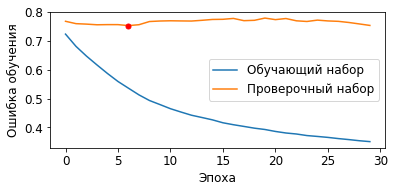

Acc =  0.48204419889502764


Epoch 1: 100%|██████████| 137/137 [00:11<00:00, 12.10it/s]


2023-06-06 19:23:22.514744 Epoch 1, Train loss 0.750, Val loss 0.703, Acc_val = 0.57


Epoch 2: 100%|██████████| 137/137 [00:11<00:00, 12.11it/s]


2023-06-06 19:23:34.122366 Epoch 2, Train loss 0.718, Val loss 0.669, Acc_val = 0.63


Epoch 3: 100%|██████████| 137/137 [00:11<00:00, 12.27it/s]


2023-06-06 19:23:45.564621 Epoch 3, Train loss 0.695, Val loss 0.644, Acc_val = 0.65


Epoch 4: 100%|██████████| 137/137 [00:11<00:00, 12.23it/s]


2023-06-06 19:23:57.061116 Epoch 4, Train loss 0.674, Val loss 0.617, Acc_val = 0.70


Epoch 5: 100%|██████████| 137/137 [00:11<00:00, 12.25it/s]


2023-06-06 19:24:08.571297 Epoch 5, Train loss 0.651, Val loss 0.596, Acc_val = 0.72


Epoch 6: 100%|██████████| 137/137 [00:11<00:00, 12.01it/s]


2023-06-06 19:24:20.277506 Epoch 6, Train loss 0.630, Val loss 0.570, Acc_val = 0.74


Epoch 7: 100%|██████████| 137/137 [00:11<00:00, 12.09it/s]


2023-06-06 19:24:31.885034 Epoch 7, Train loss 0.610, Val loss 0.549, Acc_val = 0.76


Epoch 8: 100%|██████████| 137/137 [00:11<00:00, 12.05it/s]


2023-06-06 19:24:43.545135 Epoch 8, Train loss 0.591, Val loss 0.529, Acc_val = 0.79


Epoch 9: 100%|██████████| 137/137 [00:12<00:00, 10.62it/s]


2023-06-06 19:24:56.759776 Epoch 9, Train loss 0.571, Val loss 0.500, Acc_val = 0.84


Epoch 10: 100%|██████████| 137/137 [00:12<00:00, 10.90it/s]


2023-06-06 19:25:09.607741 Epoch 10, Train loss 0.556, Val loss 0.485, Acc_val = 0.86


Epoch 11: 100%|██████████| 137/137 [00:11<00:00, 12.08it/s]


2023-06-06 19:25:21.225880 Epoch 11, Train loss 0.541, Val loss 0.477, Acc_val = 0.86


Epoch 12: 100%|██████████| 137/137 [00:11<00:00, 11.87it/s]


2023-06-06 19:25:33.083208 Epoch 12, Train loss 0.528, Val loss 0.459, Acc_val = 0.88


Epoch 13: 100%|██████████| 137/137 [00:11<00:00, 12.02it/s]


2023-06-06 19:25:44.764932 Epoch 13, Train loss 0.516, Val loss 0.445, Acc_val = 0.90


Epoch 14: 100%|██████████| 137/137 [00:11<00:00, 12.20it/s]


2023-06-06 19:25:56.285683 Epoch 14, Train loss 0.506, Val loss 0.433, Acc_val = 0.92


Epoch 15: 100%|██████████| 137/137 [00:11<00:00, 12.15it/s]


2023-06-06 19:26:07.848509 Epoch 15, Train loss 0.496, Val loss 0.422, Acc_val = 0.94


Epoch 16: 100%|██████████| 137/137 [00:11<00:00, 12.18it/s]


2023-06-06 19:26:19.372108 Epoch 16, Train loss 0.487, Val loss 0.403, Acc_val = 0.97


Epoch 17: 100%|██████████| 137/137 [00:11<00:00, 12.01it/s]


2023-06-06 19:26:31.045271 Epoch 17, Train loss 0.480, Val loss 0.402, Acc_val = 0.96


Epoch 18: 100%|██████████| 137/137 [00:11<00:00, 12.20it/s]


2023-06-06 19:26:42.551593 Epoch 18, Train loss 0.471, Val loss 0.390, Acc_val = 0.98


Epoch 19: 100%|██████████| 137/137 [00:11<00:00, 11.98it/s]


2023-06-06 19:26:54.286073 Epoch 19, Train loss 0.465, Val loss 0.377, Acc_val = 0.99


Epoch 20: 100%|██████████| 137/137 [00:11<00:00, 12.14it/s]


2023-06-06 19:27:05.841198 Epoch 20, Train loss 0.458, Val loss 0.366, Acc_val = 0.99


Epoch 21: 100%|██████████| 137/137 [00:11<00:00, 12.01it/s]


2023-06-06 19:27:17.544382 Epoch 21, Train loss 0.450, Val loss 0.363, Acc_val = 0.99


Epoch 22: 100%|██████████| 137/137 [00:11<00:00, 12.13it/s]


2023-06-06 19:27:29.124867 Epoch 22, Train loss 0.445, Val loss 0.350, Acc_val = 0.99


Epoch 23: 100%|██████████| 137/137 [00:11<00:00, 12.14it/s]


2023-06-06 19:27:40.683779 Epoch 23, Train loss 0.438, Val loss 0.340, Acc_val = 0.99


Epoch 24: 100%|██████████| 137/137 [00:11<00:00, 12.24it/s]


2023-06-06 19:27:52.154272 Epoch 24, Train loss 0.433, Val loss 0.339, Acc_val = 0.99


Epoch 25: 100%|██████████| 137/137 [00:11<00:00, 12.26it/s]


2023-06-06 19:28:03.609743 Epoch 25, Train loss 0.426, Val loss 0.332, Acc_val = 1.00


Epoch 26: 100%|██████████| 137/137 [00:11<00:00, 12.01it/s]


2023-06-06 19:28:15.299022 Epoch 26, Train loss 0.420, Val loss 0.316, Acc_val = 1.00


Epoch 27: 100%|██████████| 137/137 [00:11<00:00, 12.21it/s]


2023-06-06 19:28:26.803844 Epoch 27, Train loss 0.415, Val loss 0.321, Acc_val = 1.00


Epoch 28: 100%|██████████| 137/137 [00:11<00:00, 12.05it/s]


2023-06-06 19:28:38.467427 Epoch 28, Train loss 0.409, Val loss 0.302, Acc_val = 1.00


Epoch 29: 100%|██████████| 137/137 [00:11<00:00, 12.09it/s]


2023-06-06 19:28:50.085092 Epoch 29, Train loss 0.402, Val loss 0.300, Acc_val = 1.00


Epoch 30: 100%|██████████| 137/137 [00:11<00:00, 12.21it/s]


2023-06-06 19:29:01.575962 Epoch 30, Train loss 0.397, Val loss 0.285, Acc_val = 1.00


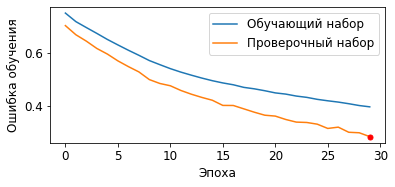

Acc =  0.6989277652370203


Epoch 1: 100%|██████████| 126/126 [00:10<00:00, 12.36it/s]


2023-06-06 19:29:21.755181 Epoch 1, Train loss 0.764, Val loss 0.739, Acc_val = 0.50


Epoch 2: 100%|██████████| 126/126 [00:10<00:00, 12.25it/s]


2023-06-06 19:29:32.483222 Epoch 2, Train loss 0.735, Val loss 0.735, Acc_val = 0.51


Epoch 3: 100%|██████████| 126/126 [00:10<00:00, 12.20it/s]


2023-06-06 19:29:43.255381 Epoch 3, Train loss 0.717, Val loss 0.715, Acc_val = 0.53


Epoch 4: 100%|██████████| 126/126 [00:10<00:00, 12.29it/s]


2023-06-06 19:29:53.944887 Epoch 4, Train loss 0.701, Val loss 0.713, Acc_val = 0.55


Epoch 5: 100%|██████████| 126/126 [00:10<00:00, 12.16it/s]


2023-06-06 19:30:04.803772 Epoch 5, Train loss 0.688, Val loss 0.689, Acc_val = 0.59


Epoch 6: 100%|██████████| 126/126 [00:10<00:00, 12.23it/s]


2023-06-06 19:30:15.547368 Epoch 6, Train loss 0.676, Val loss 0.674, Acc_val = 0.60


Epoch 7: 100%|██████████| 126/126 [00:10<00:00, 12.24it/s]


2023-06-06 19:30:26.270811 Epoch 7, Train loss 0.663, Val loss 0.662, Acc_val = 0.61


Epoch 8: 100%|██████████| 126/126 [00:10<00:00, 12.23it/s]


2023-06-06 19:30:37.027721 Epoch 8, Train loss 0.653, Val loss 0.653, Acc_val = 0.61


Epoch 9: 100%|██████████| 126/126 [00:10<00:00, 12.15it/s]


2023-06-06 19:30:47.827849 Epoch 9, Train loss 0.641, Val loss 0.644, Acc_val = 0.61


Epoch 10: 100%|██████████| 126/126 [00:10<00:00, 12.18it/s]


2023-06-06 19:30:58.624461 Epoch 10, Train loss 0.631, Val loss 0.627, Acc_val = 0.62


Epoch 11: 100%|██████████| 126/126 [00:10<00:00, 12.21it/s]


2023-06-06 19:31:09.422796 Epoch 11, Train loss 0.621, Val loss 0.621, Acc_val = 0.60


Epoch 12: 100%|██████████| 126/126 [00:10<00:00, 12.15it/s]


2023-06-06 19:31:20.241356 Epoch 12, Train loss 0.612, Val loss 0.608, Acc_val = 0.61


Epoch 13: 100%|██████████| 126/126 [00:10<00:00, 12.17it/s]


2023-06-06 19:31:31.047585 Epoch 13, Train loss 0.604, Val loss 0.603, Acc_val = 0.59


Epoch 14: 100%|██████████| 126/126 [00:10<00:00, 12.11it/s]


2023-06-06 19:31:41.888132 Epoch 14, Train loss 0.595, Val loss 0.590, Acc_val = 0.62


Epoch 15: 100%|██████████| 126/126 [00:10<00:00, 12.26it/s]


2023-06-06 19:31:52.610073 Epoch 15, Train loss 0.587, Val loss 0.589, Acc_val = 0.59


Epoch 16: 100%|██████████| 126/126 [00:10<00:00, 12.24it/s]


2023-06-06 19:32:03.333064 Epoch 16, Train loss 0.580, Val loss 0.584, Acc_val = 0.58


Epoch 17: 100%|██████████| 126/126 [00:10<00:00, 12.25it/s]


2023-06-06 19:32:14.046450 Epoch 17, Train loss 0.573, Val loss 0.580, Acc_val = 0.57


Epoch 18: 100%|██████████| 126/126 [00:10<00:00, 12.19it/s]


2023-06-06 19:32:24.837439 Epoch 18, Train loss 0.569, Val loss 0.569, Acc_val = 0.61


Epoch 19: 100%|██████████| 126/126 [00:10<00:00, 11.57it/s]


2023-06-06 19:32:36.167059 Epoch 19, Train loss 0.561, Val loss 0.574, Acc_val = 0.57


Epoch 20: 100%|██████████| 126/126 [00:10<00:00, 11.98it/s]


2023-06-06 19:32:47.131970 Epoch 20, Train loss 0.554, Val loss 0.567, Acc_val = 0.58


Epoch 21: 100%|██████████| 126/126 [00:10<00:00, 12.19it/s]


2023-06-06 19:32:57.897646 Epoch 21, Train loss 0.549, Val loss 0.569, Acc_val = 0.54


Epoch 22: 100%|██████████| 126/126 [00:10<00:00, 12.04it/s]


2023-06-06 19:33:08.791597 Epoch 22, Train loss 0.545, Val loss 0.560, Acc_val = 0.57


Epoch 23: 100%|██████████| 126/126 [00:10<00:00, 12.13it/s]


2023-06-06 19:33:19.642452 Epoch 23, Train loss 0.540, Val loss 0.552, Acc_val = 0.60


Epoch 24: 100%|██████████| 126/126 [00:10<00:00, 12.22it/s]


2023-06-06 19:33:30.415309 Epoch 24, Train loss 0.533, Val loss 0.549, Acc_val = 0.59


Epoch 25: 100%|██████████| 126/126 [00:10<00:00, 12.19it/s]


2023-06-06 19:33:41.175678 Epoch 25, Train loss 0.529, Val loss 0.543, Acc_val = 0.61


Epoch 26: 100%|██████████| 126/126 [00:10<00:00, 12.21it/s]


2023-06-06 19:33:51.937938 Epoch 26, Train loss 0.524, Val loss 0.549, Acc_val = 0.56


Epoch 27: 100%|██████████| 126/126 [00:11<00:00, 10.64it/s]


2023-06-06 19:34:04.366152 Epoch 27, Train loss 0.520, Val loss 0.542, Acc_val = 0.58


Epoch 28: 100%|██████████| 126/126 [00:11<00:00, 10.64it/s]


2023-06-06 19:34:16.668856 Epoch 28, Train loss 0.514, Val loss 0.544, Acc_val = 0.56


Epoch 29: 100%|██████████| 126/126 [00:11<00:00, 10.79it/s]


2023-06-06 19:34:28.836159 Epoch 29, Train loss 0.509, Val loss 0.533, Acc_val = 0.59


Epoch 30: 100%|██████████| 126/126 [00:11<00:00, 11.06it/s]


2023-06-06 19:34:40.670051 Epoch 30, Train loss 0.505, Val loss 0.531, Acc_val = 0.59


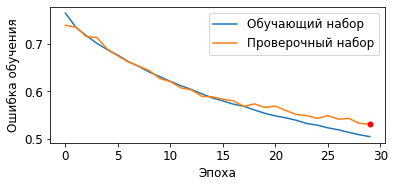

Acc =  0.9166666666666666
Final results
30 epochs. Acc_sk = 0.72 (Sens = 0.72 / Spec = 0.72) 0.75 / 0.77 / 0.48 / 0.70 / 0.92


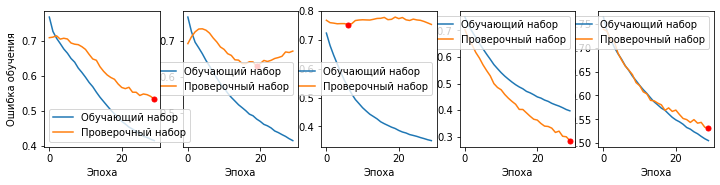

In [77]:
import os
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()
# model = ALS_CNN()

# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 40 epochs. Acc_sk = 0.70 (Sens = 0.74 / Spec = 0.66) 0.68 / 0.86 / 0.52 / 0.76 / 0.77
# self.layer1_filt = 2 (before 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.66 (Sens = 0.62 / Spec = 0.70) 0.68 / 0.55 / 0.57 / 0.62 / 0.88
# max_pool_width = 4 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.59 (Sens = 0.53 / Spec = 0.65) 0.65 / 0.50 / 0.56 / 0.61 / 0.63
# self.layer1_filt = 4 + max_pool_width = 4 + lf1_height, lf1_width = 29,43
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.65 (Sens = 0.61 / Spec = 0.69) 0.61 / 0.62 / 0.60 / 0.65 / 0.75 (good behaviour)
# mf2_height,mf2_width = 15,43 (before 15x17)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.70) 0.71 / 0.69 / 0.53 / 0.75 / 0.90
# hf4_height,hf4_width = 15,43 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.76 / Spec = 0.64) 0.73 / 0.66 / 0.53 / 0.73 / 0.86
# hf4_height,hf4_width = 15,31 (before 15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.77 / Spec = 0.64) 0.67 / 0.79 / 0.51 / 0.68 / 0.89
# hf3_height,hf3_width = 13,27 (before 11x11)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.70) 0.78 / 0.86 / 0.53 / 0.74 / 0.89
# mf_height,mf_width = 13,27 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.77 / Spec = 0.75) 0.78 / 0.82 / 0.62 / 0.73 / 0.88
# lf3_height, lf3_width = 13,27 (3x7)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.73) 0.72 / 0.81 / 0.65 / 0.72 / 0.87
# lf3_height, lf3_width = 25,39 (13x27)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.72) 0.65 / 0.67 / 0.62 / 0.74 / 0.92  (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.69 / 0.79 / 0.63 / 0.71 / 0.88
# lf3_height, lf3_width = 5,11
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.72) 0.63 / 0.82 / 0.64 / 0.75 / 0.88
# model with diff input. Now there is 2 input chanells: x and x_diff
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.66 / Spec = 0.76) 0.69 / 0.66 / 0.58 / 0.67 / 0.91
# self.layer1_filt = 6 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.80 / Spec = 0.76) 0.70 / 0.80 / 0.69 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 30 epochs. Acc_sk = 0.77 (Sens = 0.79 / Spec = 0.74) 0.71 / 0.79 / 0.65 / 0.76 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 30 epochs. Acc_sk = 0.77 (Sens = 0.76 / Spec = 0.77) 0.70 / 0.74 / 0.68 / 0.72 / 0.94
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 20 epochs. Acc_sk = 0.71 (Sens = 0.69 / Spec = 0.74) 0.66 / 0.80 / 0.64 / 0.71 / 0.81
# hf_height,hf_width = 9,9 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.75) 0.66 / 0.82 / 0.61 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.75 / Spec = 0.74) 0.75 / 0.78 / 0.62 / 0.72 / 0.87
# hf_height,hf_width = 3,3 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 35 epochs. Acc_sk = 0.77 (Sens = 0.78 / Spec = 0.75) 0.70 / 0.82 / 0.66 / 0.75 / 0.89 (32 min)
# big context on each subband
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.68 (Sens = 0.72 / Spec = 0.64) 0.60 / 0.80 / 0.57 / 0.70 / 0.78
# hf2_height,hf2_width = 13,27 (15x31)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.71 / Spec = 0.67) 0.66 / 0.73 / 0.57 / 0.68 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.76 / Spec = 0.70) 0.68 / 0.85 / 0.59 / 0.75 / 0.83
# mf2_height,mf2_width = 11,31 (15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.72 / Spec = 0.67) 0.62 / 0.87 / 0.57 / 0.67 / 0.86
# Val set balanced + golden section convs
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.75 / Spec = 0.76) 0.68 / 0.78 / 0.70 / 0.71 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.75 (Sens = 0.75 / Spec = 0.75) 0.71 / 0.82 / 0.71 / 0.72 / 0.82
# self.layer1_filt = 2 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.74 (Sens = 0.74 / Spec = 0.74) 0.68 / 0.73 / 0.63 / 0.71 / 0.88
# self.layer1_filt = 1 (before 2)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.74 (Sens = 0.71 / Spec = 0.76) 0.75 / 0.83 / 0.69 / 0.67 / 0.79
# optimizer = optim.Adam(model.parameters(),lr=5e-5, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.74 (Sens = 0.73 / Spec = 0.76) 0.75 / 0.85 / 0.67 / 0.67 / 0.82
# self.layer1_filt = 2 (before 1)
# optimizer = optim.Adam(model.parameters(),lr=5e-5, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.73 (Sens = 0.72 / Spec = 0.75) 0.76 / 0.75 / 0.65 / 0.71 / 0.78
# self.layer1_filt = 1 (before 2) + lf4_height, lf4_width = 11,19 (9x11 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.67 (Sens = 0.68 / Spec = 0.66) 0.68 / 0.81 / 0.53 / 0.62 / 0.70
# lf4_height, lf4_width = 9,11 (11x19 before) + lf3_height, lf3_width = 9,11 (11x19 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.74 (Sens = 0.69 / Spec = 0.79) 0.72 / 0.81 / 0.65 / 0.65 / 0.83
# lf3_height, lf3_width = 11,19 (return). Default convs
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# ...
# self.layer1_filt = 4 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.77 / Spec = 0.79) 0.80 / 0.83 / 0.68 / 0.75 / 0.86
# self.layer1_filt_hf = 1 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.72 / Spec = 0.74) 0.73 / 0.81 / 0.64 / 0.70 / 0.83
# self.layer1_filt_hf = 4 (before 1) + mf5_height,mf5_width =  15,9
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.78 / Spec = 0.77) 0.78 / 0.82 / 0.60 / 0.72 / 0.93
# best model selection problem fixed
# self.layer1_filt = 1 + self.layer1_filt_hf = 1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.67) 0.65 / 0.72 / 0.48 / 0.66 / 0.85
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.72 (Sens = 0.72 / Spec = 0.72) 0.75 / 0.77 / 0.48 / 0.70 / 0.92
# self.layer1_filt = 4 + self.layer1_filt_hf = 1
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=30)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
